# RBM emulator for coupled channels scattering

We would like to construct an emulator for a toy problem for inelastic nucleon-nucleus scattering in which we explicitly include a few excited states of the target in our model space. We will use a simple model with two excited states, with Woods-Saxon form factors on the diagonal, and Gaussian off the diagonal.

\begin{equation}
 H_{int} = 
 \begin{bmatrix}
   V(r) & \beta g(r) & \beta g(r) \\
  \beta g(r) & V(r) & \gamma g(r) \\
  \beta g(r) & \gamma g(r) & V(r) \\
 \end{bmatrix},
\end{equation}

where 

\begin{equation}
V(r) = \frac{V+iW}{1 + \exp{ \left( \frac{r-R}{a} \right) }},
\end{equation}

and 

\begin{equation}
g(r) = \exp{ \left( -\frac{r^2}{\alpha^2} \right) }.
\end{equation}

In this toy model, the real part of the Woods-Saxon in the $n$th diagonal represents the interaction of the projectile and target in the $n$th excited state, with $n=0$ being the ground state (and, therefore, the elastic channel). The imaginary component represents the transition from the $n$th channel to other excited states not explicitly included in the model space ($n$ > 2). The off-diagonal terms represent coupling between channels, with $\beta$ controlling the strength of coupling of the ground state to each excited state, and $\gamma$ between excited states.

The Schroedinger-like equation governing scattering in channel $n$ will look like [1, eq. (75)]:


\begin{equation}
\left( - \frac{\hbar^2}{2\mu}\nabla^2_{\vec r} + V(\vec r) - E_n \right) \psi_n(\vec r) = - \sum_{m \neq n} g_{mn}(\vec r) \psi_m(\vec r),
\end{equation}

where $E_n$ is the asymptotic kinetic energy in channel $n$ (total energy minus the energy of internal state $n$ of the system), and


\begin{equation}
g_{mn}(r) = \begin{cases} 
    \beta g(r) & m = 0 \lor n = 0 \\
    \gamma g(r) & \text{else}
\end{cases}
\end{equation}

In the case that $\gamma = 0$, this is equivalent to the distorted-wave Born approximation for the excited channels. If we turn on coupling between states with $\gamma \neq 0$, then this is a full coupled-channels calculation.


If the potentials are central and do not couple the particles spins, the projectile-target relative orbital angular momentum, $l$, is conserved and each wave-function can be expanded in partial waves as in ref. [1, eq. (36)]. It is then sufficient to solve independently the problem for each fixed value of $l$, reducing eq.(4) to


\begin{equation}
\left( - \frac{\hbar^2}{2\mu}\frac{d^2}{dr^2} + \frac{\hbar^2}{2\mu} \frac{\ell(\ell+1)}{r^2} + V(r) - E_n \right) \psi_{n,l}(r) = - \sum_{m \neq n} g_{mn}(r) \psi_{m,l}(r) .
\end{equation}


[1]: Moro A. M., Models for nuclear reactions with weakly bound systems, https://arxiv.org/abs/1807.04349.

In the following, we will make the change of variables $s = k_n  r$, with the wavenumber in a channel $k_n$ in fm $^{-1}$ defined by $E_n \equiv E_{\rm inc} - \Delta_n =\hbar^2 c^2 k_n^2 / (2 \mu)$, and $\Delta_n$ is the energy difference between the $n$ th excited state and the ground state, resulting in the following set of coupled equations:

\begin{equation}
 \left( -\frac{d^2}{ds^2} +  \frac{\ell(\ell+1)}{s^2} +  \frac{\tilde V_n(s)}{E_n} - 1 \right) \tilde\psi_{n,l}(s) + \sum_{m \neq n}  \frac{\tilde g_{mn}(s)}{E_n} \tilde\psi_{m,l}(s) = 0,
\end{equation}

Where $\tilde V_n(s) \equiv V(s/k_n)$, with $V$ being the original function $V(r)$ in eq. 2, and $\tilde g$ and $\tilde\psi$ are defined analogously. For brevity, the ~ symbols are dropped in the following. In the code below, $E_n$, $V_n$ and $g_{mn}$ are given in units of MeV, and $\mu$ in units of MeV / c$^2$.

It should be noted that our model describes scattering of a particle on a spinless target, with spinless excited states. If we set our ground or excited states to non-zero angular momenta, then partial waves ( $l$ states) would be coupled to eachother within and across energy levels, significantly increases the complexity of the system. We begin with such vastly simplified toy model to explore the construction of the reduced basis without confounding technical details.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import diags

In [18]:
# Constants
hbarc = 197 # MeV • fm
mass = 939 # MeV / c^2. Reduced mass of the system.

# Potential parameters
V0 = 60  # real potential strength
W0 = 20  # imag potential strength
R = 4  # Woods-Saxon potential radius
a = 0.5  # Woods-Saxon potential diffuseness

E_inc = 13.4   # bombarding energy in COM frame
l = 0      # Angular momentum quantum number

# strength of transition potentials MeV
beta = 20
gamma = 5

# range of transition potential
alpha = 5 # fm

# energy difference from groud state in each channel [MeV]. This is called $\Delta_n$ in the introductory text.
channel_excitation_energies = [0, 2, 4]

params_diag = (V0, W0, R, a)
params_transition = (alpha, beta, gamma)

def wave_number(energy : float) :
    return np.sqrt( 2 * mass * energy) / hbarc

#def k_channel(channelExcitationEnergy : float, E_inc : float):
#    E_channel = E_inc - channelExcitationEnergy #The channel kinetic energy
#    return wave_number(E_channel)

In [15]:
def diag_potential(r : float, E_channel : float, params: tuple):
    """
    Woods-Saxon
    """
    #Woods-Saxon with change of variable s = k * r :
    #if s=r*k, S=R*k, d=a*k, then (s - S) / d) = (r - R) / a, thus no need to actually change variable here.
    V, W, R, a = params
    #E = hbarc*hbarc k*k/(2*mass)
    return -(V0 + W) / (1 + np.exp((r - R) / a)) / E_channel
    
def transition_potential(r : float, E_channel : float, params : tuple):
    """
    Gaussian
    """
    alpha, _ , _ = params
    #E = hbarc*hbarc/(2*mass)
    #d = alpha * k
    #s = r * k
    return np.exp( -r**2 / alpha**2) / E_channel

def full_diag_term(r : float, E_channel : float,  l : int, params_diag : tuple):
    k = wave_number(E_channel)
    s = k * r
    return diag_potential(r, E_channel, params_diag) + l * (l + 1) / s**2 - 1.0


def schrodinger_eqn(r, y, E_inc : float, l : int, channel_excitation_energies : list, params_diag : tuple, params_transition : tuple):
    """
    callback for scipy.integrate.solve_ivp. Takes in domain (r) and state (y)
    and returns dy/dr according to the RHS of the Schroedinger eqn.
    State (y) is the wavefunctions in each channel and their first derivatives, e.g.:
    [psi_0, psi_1, psi_2, psi_0', psi_1', psi_2']. 
    """
    alpha, beta, gamma = params_transition
    V, W, R, a = params_diag
    #k = [k_channel(channelExcitationEnergy, E_inc) for channelExcitationEnergy in channel_excitation_energies ]
    E_channels = [ E_inc - channelExcitationEnergy for channelExcitationEnergy in channel_excitation_energies ]
    
    psi = y[0:3]
    psi_prime = y[3:3*2]
    
    psi_double_prime = [
        # psi_0''
        full_diag_term(r, E_channels[0], l, params_diag) * psi[0] 
      + beta * transition_potential(r, E_channels[1] , params_transition) * psi[1] 
      + beta * transition_potential(r, E_channels[2] , params_transition) * psi[2],
      # psi_1 ''
        beta * transition_potential(r, E_channels[0] , params_transition) * psi[0] 
      + full_diag_term(r, E_channels[1], l, params_diag) * psi[1] 
      + gamma * transition_potential(r, E_channels[2] , params_transition) * psi[2],
      # psi_2''
        beta * transition_potential(r, E_channels[0] , params_transition) * psi[0] 
      + gamma * transition_potential(r, E_channels[1] , params_transition) * psi[1]
      + full_diag_term(r, E_channels[2], l, params_diag) * psi[2] 
     ]

    return [ psi_prime[0] , psi_prime[1], psi_prime[2], psi_double_prime[0], psi_double_prime[1], psi_double_prime[2]] 




In [16]:
def solve_coupled_channels(E_inc : float, l : int, channel_excitation_energies : list,  params_diag : tuple, params_transition : tuple):
    alpha = params_transition
    V, W, R, a = params_diag

    # Integration parameters
    r_start = 0.05  # Initial position
    r_end=70  # Final position

    corr_factor=10

    # Initial conditions
    psi0 = corr_factor*r_start**(l+1) *(1. + 1.j) # Initial wavefunction value
    psi_prime0 = corr_factor*(l+1)*r_start**(l) *(1. + 1.j) # Initial derivative value

    sol = solve_ivp(
        lambda r, y: schrodinger_eqn(r, y, E_inc, l, channel_excitation_energies, params_diag, params_transition), 
        (r_start, r_end), 
        [psi0, psi0, psi0, psi_prime0, psi_prime0, psi_prime0], 
        dense_output=True,
        #rtol=1.0e-2,
        #atol=1.0e-4
    )

    return sol.sol




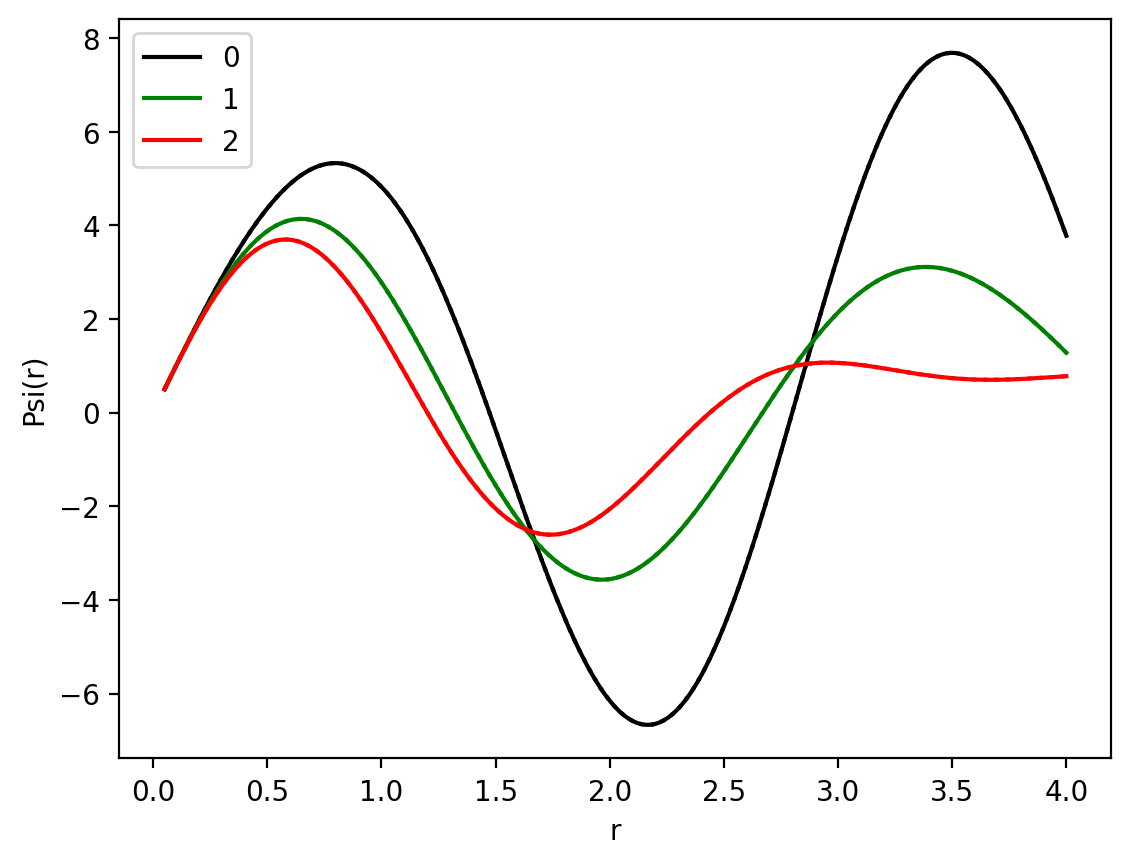

In [19]:
# Integration parameters
r_start = 0.05  # Initial position
r_end=4  # Final position

# Solve the Schrödinger equation
sol = solve_coupled_channels(E_inc, l, channel_excitation_energies, params_diag, params_transition)

# Calculate the wavefunction
r_values = np.linspace(r_start, r_end, 1000)


psinorm = [ np.trapz(np.real(psi)**2 + np.imag(psi)**2, r_values) for psi in sol(r_values) ]
psi = [ psi for psi, norm in zip(sol(r_values), psinorm) ]


# plot wavefunction in each channel
fig = plt.figure(dpi=200)
plt.plot(r_values, np.real(psi[0]), 'k', label="0")
plt.plot(r_values, np.imag(psi[0]), ':k')

plt.plot(r_values, np.real(psi[1]), 'g', label="1")
plt.plot(r_values, np.imag(psi[1]), ':g')

plt.plot(r_values, np.real(psi[2]), 'r', label="2")
plt.plot(r_values, np.imag(psi[2]), ':r')

plt.xlabel('r')
plt.legend()
plt.ylabel('Psi(r)')
plt.show()

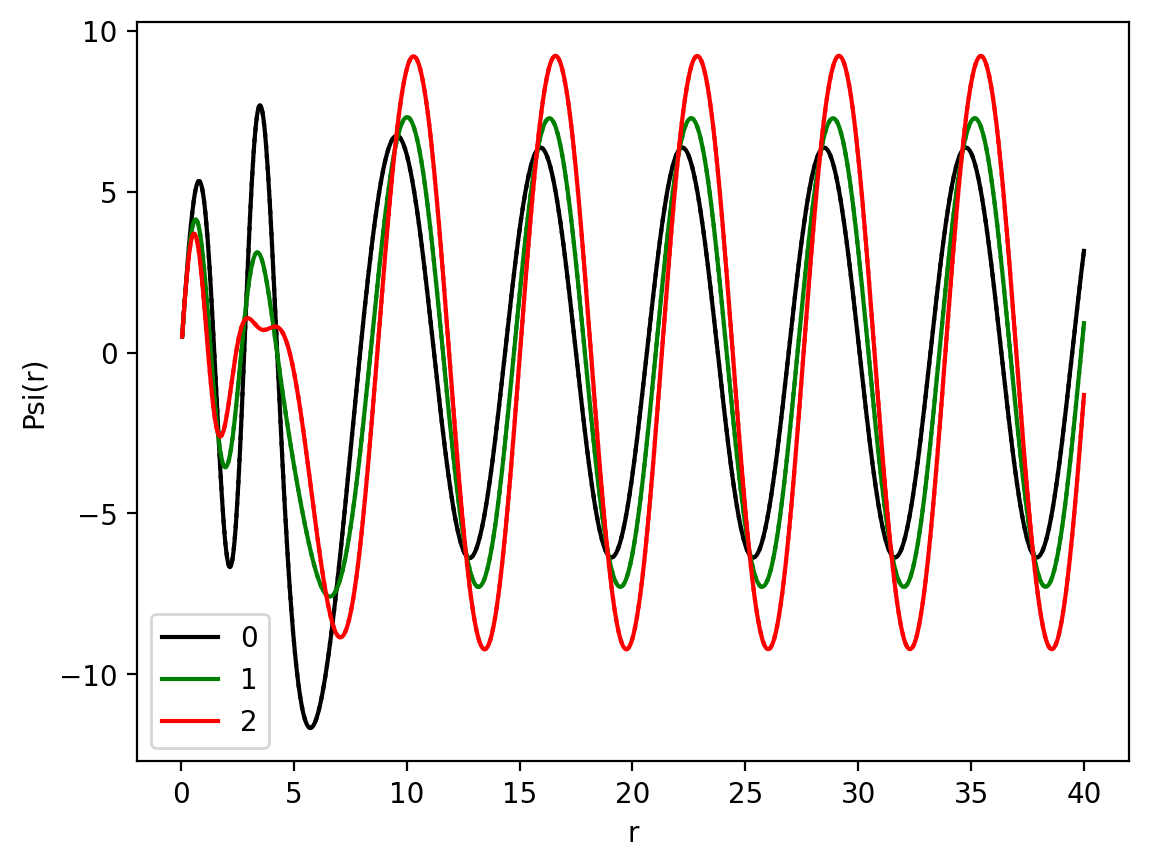

In [20]:
# Integration parameters
r_start = 0.05  # Initial position
r_end=40  # Final position

# Solve the Schrödinger equation
sol = solve_coupled_channels(E_inc, l, channel_excitation_energies, params_diag, params_transition)

# Calculate the wavefunction
r_values = np.linspace(r_start, r_end, 1000)


psinorm = [ np.trapz(np.real(psi)**2 + np.imag(psi)**2, r_values) for psi in sol(r_values) ]
psi = [ psi for psi, norm in zip(sol(r_values), psinorm) ]


# plot wavefunction in each channel
fig = plt.figure(dpi=200)
plt.plot(r_values, np.real(psi[0]), 'k', label="0")
plt.plot(r_values, np.imag(psi[0]), ':k')

plt.plot(r_values, np.real(psi[1]), 'g', label="1")
plt.plot(r_values, np.imag(psi[1]), ':g')

plt.plot(r_values, np.real(psi[2]), 'r', label="2")
plt.plot(r_values, np.imag(psi[2]), ':r')

plt.xlabel('r')
plt.legend()
plt.ylabel('Psi(r)')
plt.show()